## Imports

In [1]:
%env CUDA_VISIBLE_DEVICES=1
%env TF_CPP_MIN_LOG_LEVEL=1
%env TF_CPP_MIN_VLOG_LEVEL=1
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=1
env: TF_CPP_MIN_LOG_LEVEL=1
env: TF_CPP_MIN_VLOG_LEVEL=1


In [2]:
import os                                                                       
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 
os.environ['TF_CPP_MIN_VLOG_LEVEL'] = '1' 
import numpy as np                                                              
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf                                                         
tf.logging.set_verbosity(tf.logging.ERROR)
import data.data_selector as ds                                                   
import utils.data_processing as dp
import utils.plot_functions as pf                                               
import analysis.analysis_picker as ap

In [3]:
analysis_params = {
  "model_type": "ica",
  "model_name": "ica",
  "data_type": "vanHateren",
  "num_patches": 1e4,
  "device": "/gpu:0",
  "version": "1.0",
  "ft_padding": 32, #Fourier analysis padding for weight fitting
  "clobber": False}

# Computed params
analysis_params["model_dir"] = (os.path.expanduser("~")+"/Work/Projects/"
  +analysis_params["model_name"])

In [4]:
analyzer = ap.get_analyzer(analysis_params)

In [5]:
analyzer.model_params["data_type"] = analysis_params["data_type"]
analyzer.model_params["num_patches"] = analysis_params["num_patches"]
data = ds.get_data(analyzer.model_params)
data = analyzer.model.preprocess_dataset(data, analyzer.model_params)
data = analyzer.model.reshape_dataset(data, analyzer.model_params)
analyzer.model_params["data_shape"] = list(data["train"].shape[1:])
analyzer.model.setup(analyzer.model_params, analyzer.model_schedule)
analyzer.model_params["input_shape"] = [
  data["train"].num_rows*data["train"].num_cols*data["train"].num_channels]

In [6]:
if analysis_params["clobber"]:
  analyzer.run_analysis(data["train"].images, save_info="full_imgs")
else:
  analyzer.load_analysis(save_info="full_imgs")

In [19]:
#stats_fig = pf.plot_stats(analyzer.run_stats,
#  keys=["u_fraction_active", "a_max_grad", "a_min_grad"],
#  labels=["activity", "a max grad", "a min grad"])

In [20]:
#atas_fig = pf.plot_weights(analyzer.atas.T.reshape(256,16,16), title="Activity triggered averages on image data")

In [21]:
#noise_images = np.random.standard_normal(data["train"].images.shape) 
#noise_evals = analyzer.evaluate_model(noise_images, analyzer.var_names)
#noise_atas = analyzer.compute_atas(noise_evals["inference/coefficients:0"], noise_images)
#noise_atas_fig = pf.plot_data_tiled(noise_atas.T, normalize=False, title="Activity triggered averages on standard normal noise data")

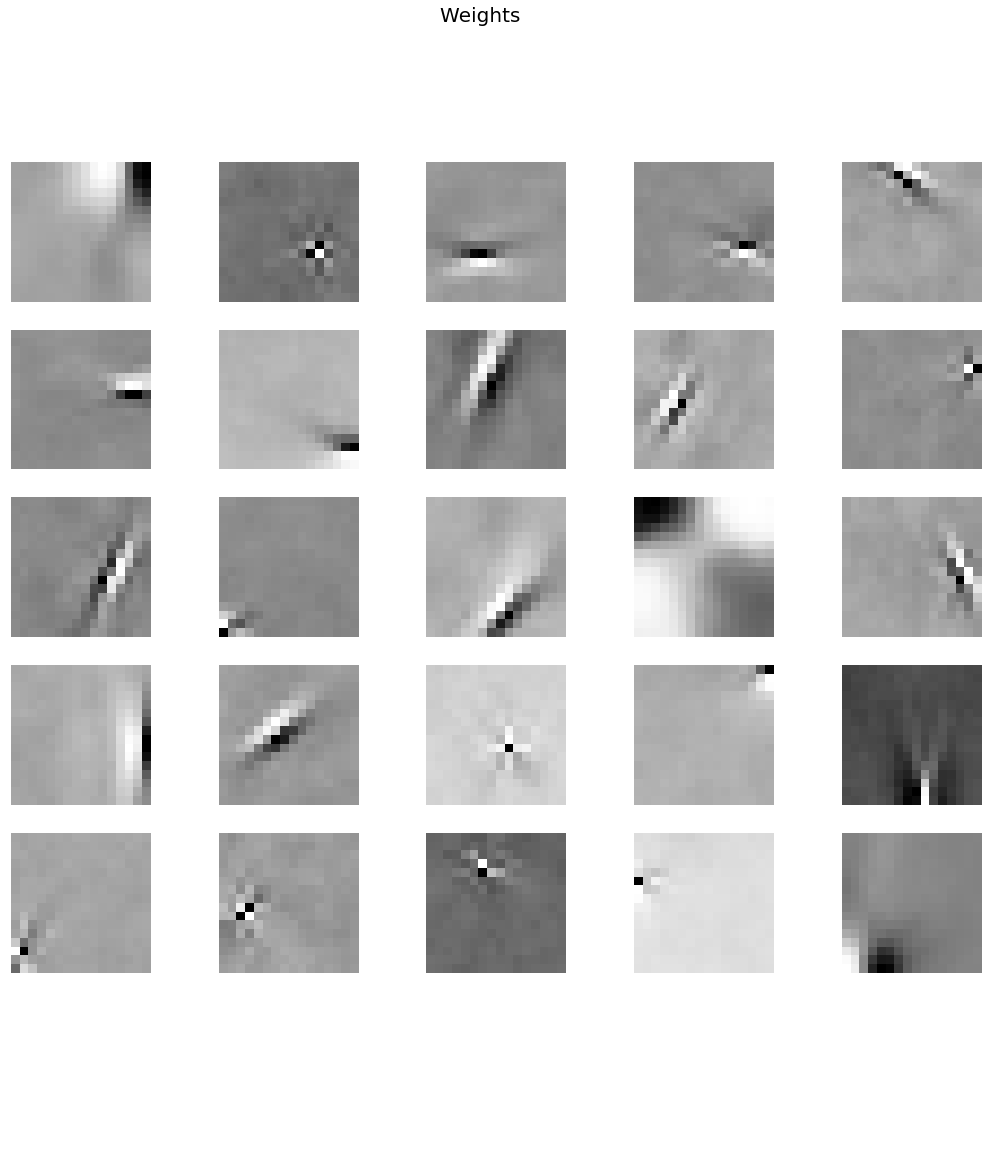

In [12]:
dict_fig = pf.plot_weights(analyzer.evals["weights/a:0"].reshape(256,16,16)[0:25,:,:], title="Weights")

In [23]:
#grating = dp.generate_grating(rf_edge=100, location=(50,50), diameter=25,
#  orientation=np.pi/4, frequency=10, phase=4*np.pi/6, contrast=0.5)
#fig, ax = plt.subplots(1, figsize=(3, 3))
#ax = pf.clear_axis(ax, spines="k")
#ax.imshow(grating, cmap="Greys_r", vmin=0, vmax=1)
#plt.show()

In [24]:
#constructed_bfs = np.zeros_like(analyzer.evals["weights/a:0"].T)
#for bf_idx in range(constructed_bfs.shape[0]):
#  params = dp.get_grating_params(analyzer.bf_stats, bf_idx)
#  grating = dp.generate_grating(*params)
#  constructed_bfs[bf_idx,...] = grating.reshape(256)
#fig = pf.plot_data_tiled(constructed_bfs)

In [25]:
#fig = pf.plot_bf_stats(analyzer.bf_stats, num_bf=10)

In [26]:
#tmp_bf_idx = 120
#fit_bf_stats = dp.get_dictionary_stats(constructed_bfs, padding=32)
#fit_spatial_frequency = fit_bf_stats["spatial_frequencies"][tmp_bf_idx]
#bf_spatial_frequency = dp.get_grating_params(analyzer.bf_stats, tmp_bf_idx)[4]
#print(fit_spatial_frequency/bf_spatial_frequency)
#print(np.pi/2)

In [27]:
#from scipy.optimize import curve_fit
#
#num_pixels = analyzer.bf_stats["patch_edge_size"]**2
#num_bfs = 49#analyzer.bf_stats["num_outputs"]
#
#def gauss(x, *p):
#  A, mu, sigma = p
#  return A*np.exp(-(x-mu)**2/(2*sigma**2))
#
#grating = lambda orientation,phase,contrast:dp.generate_grating(*dp.get_grating_params(analyzer.bf_stats,
#  bf_idx, orientation=orientation, phase=phase, contrast=contrast, diameter=-1))
#
#phases = np.linspace(-np.pi, np.pi, num_phases)
#orientations = np.linspace(-np.pi, np.pi, num_orientations)
#contrasts = np.linspace(0.4, 1.0, num_contrasts)
#contrast_activations = np.zeros((num_bfs, num_contrasts, num_orientations))
#half_widths = np.zeros((num_bfs, num_contrasts))
#phase_activations = np.zeros((num_bfs, num_contrasts, num_orientations, num_phases))
#best_phases = np.zeros((num_bfs, num_contrasts, num_orientations))
#for bf_idx in range(num_bfs):
#  for co_idx, contrast in enumerate(contrasts):
#    orientation_activations = np.zeros(num_orientations)
#    for or_idx, orientation in enumerate(orientations):
#      phase_stims = np.array([grating(orientation, phase, contrast).reshape(num_pixels) for phase in phases])
#      activity = analyzer.compute_activations(phase_stims)[:, bf_idx];
#      phase_activations[bf_idx, co_idx, or_idx, :] = activity
#      best_phases[bf_idx, co_idx, or_idx] = phases[np.argmax(activity)]
#      orientation_activations[or_idx] = np.max(activity) - np.min(activity) # peak-to-peak amplitude
#    norm_activity = orientation_activations / np.max(orientation_activations)
#    #max_idx = np.argmax(norm_activity)
#    #min_idx = np.argmin(norm_activity[:max_idx])
#    #min_idx2 = np.argmin(norm_activity[max_idx:])
#    #masked_act = norm_activity[min_idx:min_idx2]
#    #masked_ori = orientations[min_idx:min_idx2]
#    #p0 = [np.max(masked_act), np.mean(masked_act), np.std(masked_act)] # initial guess (A, mu, sigma)
#    #try:
#    #  coeff, var_matrix = curve_fit(gauss, masked_ori, masked_act, p0=p0)
#    #  half_widths[bf_idx, co_idx] = 2*np.sqrt(2*np.log(2))*coeff[2]
#    #except RuntimeError:
#    #  half_widths[bf_idx, co_idx] = None
#    contrast_activations[bf_idx, co_idx, :] = orientation_activations

#data = np.load(analyzer.analysis_out_dir+"/tuning_exp.npz")["data"]
#phases = data["phases"]
#orientations = data["orientations":orientations]
#contrasts = data["contrasts"]
#contrast_activations = data["contrast_activations"]
#half_widths = data["half_widths"]
#phase_activations = data["phase_activations"]
#best_phases = data["best_phases"]

In [7]:
contrasts = [1.0]#np.linspace(0.4, 1.0, 7)
phases = np.linspace(-np.pi, np.pi, 12)
orientations = np.linspace(-np.pi, np.pi, 64)

grating_responses = analyzer.orientation_tuning(contrasts, orientations, phases)
best_phases = grating_responses["best_phases"]
activations = grating_responses["activations"]
contrast_activations = grating_responses["contrast_activations"]
phase_activations = grating_responses["phase_activations"]
phase_stims = grating_responses["phase_stims"]

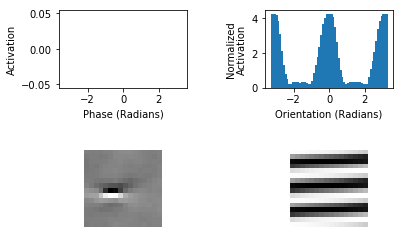

In [8]:
import matplotlib.gridspec as gridspec
grating = lambda orientation,phase,contrast:dp.generate_grating(*dp.get_grating_params(analyzer.bf_stats, bf_idx,
  orientation=orientation, phase=phase, contrast=contrast, diameter=-1))
#def plot_phase_orientation_responses(bf_idx, contrast_idx, analyzer):
bf_idx = 40#120
contrast_idx = -1
peak_orientation_idx = np.argmax(contrast_activations[bf_idx, contrast_idx])
fig = plt.figure()
gs_widths = [1, 1]
gs_heights = [1, 1]
gs = gridspec.GridSpec(2, 2, wspace=0.6, hspace=0.8, width_ratios=gs_widths, height_ratios=gs_heights)

ax = plt.subplot(gs[0,0])
ax.bar(phases, phase_activations[bf_idx, contrast_idx, peak_orientation_idx, :], width=0.3)
ax.set_xlabel("Phase (Radians)")
ax.set_ylabel("Activation")

ax = plt.subplot(gs[0,1])
ax.bar(orientations, contrast_activations[bf_idx, contrast_idx], width=0.3)
ax.set_xlabel("Orientation (Radians)")
ax.set_ylabel("Normalized\nActivation")

ax = pf.clear_axis(plt.subplot(gs[1,0]))
ax.imshow(analyzer.bf_stats["basis_functions"][bf_idx], cmap="Greys_r")

best_phase = best_phases[bf_idx, contrast_idx, peak_orientation_idx]
stim = grating(orientations[peak_orientation_idx], best_phase, contrast=1.0)
ax = pf.clear_axis(plt.subplot(gs[1,1]))
ax.imshow(stim, cmap="Greys_r")
plt.show()

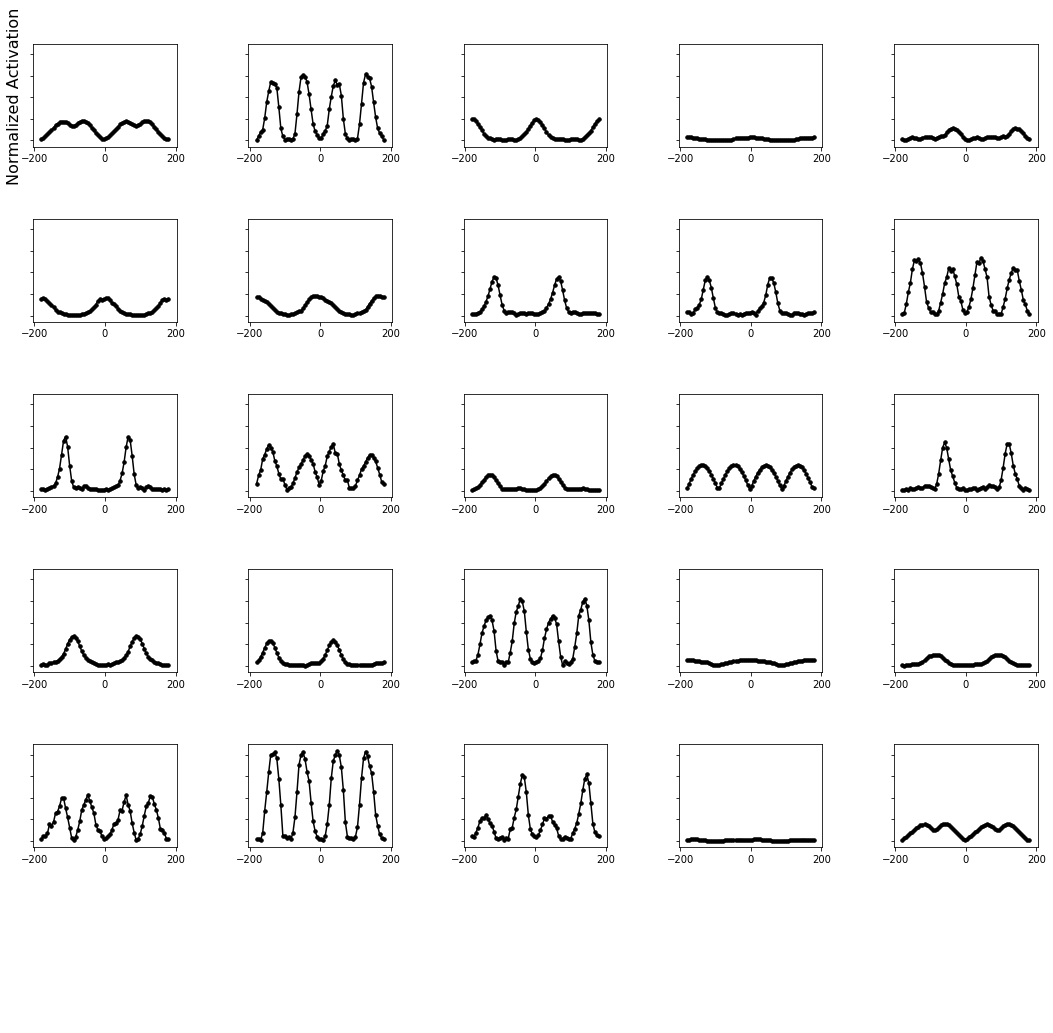

In [10]:
num_bfs = 25
cmap = plt.get_cmap('Greys')
cNorm = matplotlib.colors.Normalize(vmin=0.0, vmax=1.0)
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cmap)

fig = plt.figure(figsize=(18,18))
num_plots_y = np.int32(np.ceil(np.sqrt(num_bfs)))+1
num_plots_x = np.int32(np.ceil(np.sqrt(num_bfs)))
gs_widths = [1.0,]*num_plots_x
gs_heights = [1.0,]*num_plots_y
gs = gridspec.GridSpec(num_plots_y, num_plots_x, wspace=0.5, hspace=0.7, width_ratios=gs_widths, height_ratios=gs_heights)
bf_idx = 0
for plot_id in np.ndindex((num_plots_y, num_plots_x)):
  (y_id, x_id) = plot_id
  if y_id == 0 and x_id == 0:
    ax = fig.add_subplot(gs[plot_id])
    ax.set_ylabel("Normalized Activation", fontsize=16)
    ax00 = ax
  else:
    ax = fig.add_subplot(gs[plot_id], sharey=ax00)
  if bf_idx < num_bfs:
    for contrast, activity in zip(contrasts, contrast_activations[bf_idx,:]):
      color_val = scalarMap.to_rgba(contrast)
      ax.plot(orientations*(180/np.pi), activity, color=color_val)
      ax.scatter(orientations*(180/np.pi), activity, s=12, c=color_val)
    bf_idx += 1
  else:
    ax = pf.clear_axis(ax, spines="none")
plt.show()

In [25]:
finite_widths = half_widths[np.isfinite(half_widths)]
if np.sum(int(np.isfinite(half_widths[bf_idx,:]))) > 1:
  slope = (np.max(finite_widths[bf_idx,:]) - np.min(finite_widths[bf_idx,:]))/(np.max(contrasts) - np.min(contrasts))
  fig, ax = plt.subplots(1)
  ax.plot(contrasts, finite_widths[bf_idx,:])
  ax.set_ylim([0,np.max(finite_widths[bf_idx,:])+0.1])
  ax.text(0.4,1.0, "Slope="+"{:.3f}".format(slope))
  ax.set_xlabel("Contrast", fontsize=16)
  ax.set_ylabel("Half Width", fontsize=16)
  plt.show()

IndexError: index 49 is out of bounds for axis 0 with size 49

In [ ]:
from scipy.optimize import curve_fit

def gauss(x, *p):
  A, mu, sigma = p
  return A*np.exp(-(x-mu)**2/(2*sigma**2))

contrast_idx = 2

half_activity = contrast_activations[contrast_idx][19:51]
half_orientations = orientations[19:51]
half_activity /= np.max(contrast_activations)

a0 = np.max(half_activity)
mu0 = half_orientations[np.argmax(half_activity)]
sig0 = np.std(half_activity[half_activity>0])
p0 = [a0, mu0, sig0] # initial guess
coeff, var_matrix = curve_fit(gauss, half_orientations, half_activity, p0=p0)

half_max = coeff[0]/2
half_width = 2*np.sqrt(2*np.log(2))*coeff[2]

## Outputs
print("Max activation = ", np.max(half_activity[half_activity>0]))
print("Mean activation = ", np.mean(half_activity[half_activity>0]))
print("Std activation = ", np.std(half_activity[half_activity>0]))
print("A0 = ", a0)
print("mu0 = ", mu0)
print("sig0 = ", sig0)
print("Fitted amplitude = ", coeff[0])
print("Fitted mean = ", coeff[1])
print("Fitted standard deviation = ", coeff[2])
print("Half max = ", half_max)
print("FWHM = ", half_width)

hist_fit = gauss(half_orientations, *coeff)# Get the fitted curve
fig, ax = plt.subplots(1)
ax.scatter(half_orientations, half_activity, label="Test data")
ax.plot(half_orientations, hist_fit, c='r', label="Fitted data")
ax.plot(half_orientations, [half_max,]*len(half_orientations), 'k--', label="FWHM")
ax.legend()
plt.show()